# Initialization

## -- Import Dependencies

In [1]:
# !pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0

# Python built-in imports
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys
import re
import json
import string
from time import time
from tqdm.notebook import tqdm
import random

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import spacy

# TensorFlow specific setup
tf.keras.utils.set_random_seed(1234)

# Version check
print(f"Tensorflow version {tf.__version__}")


Tensorflow version 2.15.0


## -- GPU / TPU initialization (Colab Only)

On Google Colab, select `TPU` or `GPU` hardware accelerator.


In [2]:
def is_colab():
    return 'google.colab' in sys.modules

if is_colab():
    print('run in colab')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy()

    print(f"REPLICAS: {strategy.num_replicas_in_sync}")
else:
    print('not run in colab')

not run in colab


## -- Variable Initialization

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [10]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
if not is_colab():
    BATCH_SIZE = 512
else:
    BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512 #nodes or neuron
DROPOUT = 0.1 #// 0.2 // 0.5

EPOCHS = 1000

# Load Dataset

In [11]:
# Load the intent JSON
with open("../intents.json", "r", encoding="utf-8") as f:
    data = json.load(f)

questions = []
answers = []

# For each pattern, pair it with every response (1:many)
for intent in data['intents']:
    patterns = intent.get('patterns', [])
    responses = intent.get('responses', [])

    for pattern in patterns:
        for response in responses:
            questions.append(pattern)
            answers.append(response)

# Sample output
print("Sample:")
for q, a in list(zip(questions, answers))[:6]:
    print(f"Q: {q}\nA: {a}\n")

# Summary of questions and answers
n_question = len(questions)
n_answer = len(answers)
unique_questions = len(set(questions))
unique_answers = len(set(answers))

print(f"Total questions: {n_question}")
print(f"Total answers: {n_answer}")
print(f"Unique questions: {unique_questions}")
print(f"Unique answers: {unique_answers}")


Sample:
Q: Hi
A: Hello!

Q: Hi
A: Hello, $_user!

Q: Hi
A: Good to see you again!

Q: Hi
A: Hi there, how can I help?

Q: Hi
A: Hello!

Q: Hi
A: Hello, $_user!

Total questions: 542
Total answers: 542
Unique questions: 397
Unique answers: 50


# Data Preprocessing

## -- Common Preprocessing

In [12]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [13]:
def preprocess_text_per_word(text):
    words = text.split()
    processed_words = [word.lower() for word in words]
    processed_words = [word.strip() for word in processed_words]
    processed_words = [re.sub('\s+',' ', word) for word in processed_words]
    processed_words = [word for word in processed_words if not all(char in string.punctuation for char in word.replace(' ',''))]
    
    processed_words = ' '.join(processed_words)
    return processed_words

def filter_and_skip(preprocessed_texts):
    filtered_texts = []
    skipped_indices = []
    for i, word in enumerate(preprocessed_texts):
        if word.strip() != '':
            filtered_texts.append(word)
        else:
            skipped_indices.append(i)
    return filtered_texts, skipped_indices

preprocessed_questions = [preprocess_text_per_word(text) for text in questions]
preprocessed_answers = [preprocess_text_per_word(text) for text in answers]

preprocessed_questions, skipped_indices = filter_and_skip(preprocessed_questions)
preprocessed_answers = [answer for i, answer in enumerate(preprocessed_answers) if i not in skipped_indices]


# summary
print("===== question summary =====")
print(f"Original number of texts: {len(questions)}")
print(f"Number of texts after preprocessing: {len(preprocessed_questions)}")
print(f"Number of skipped texts: {len(skipped_indices)}")
print("Sample before preprocessing:", questions[:5])
print("Sample after preprocessing:", preprocessed_questions[:5])
print()
print("===== answer summary =====")
print(f"Original number of labels: {len(preprocessed_answers) + len(skipped_indices)}")
print(f"Number of labels after preprocessing: {len(preprocessed_answers)}")
print("Sample labels before preprocessing:", preprocessed_answers[:5])

===== question summary =====
Original number of texts: 542
Number of texts after preprocessing: 538
Number of skipped texts: 4
Sample before preprocessing: ['Hi', 'Hi', 'Hi', 'Hi', 'Hi']
Sample after preprocessing: ['hi', 'hi', 'hi', 'hi', 'hi']

===== answer summary =====
Original number of labels: 542
Number of labels after preprocessing: 538
Sample labels before preprocessing: ['hello!', 'hello, $_user!', 'good to see you again!', 'hi there, how can i help?', 'hello!']


## -- Semantic Tagging

In [14]:
nlp = spacy.load("en_core_web_lg")

In [15]:
def apply_ner_tags(text):
    doc = nlp(text)
    
    tagged_tokens = []
    for token in doc:
        replaced = False
        for ent in doc.ents:
            if token.text == ent.text:
                tagged_tokens.append(f"<{ent.label_}>")
                replaced = True
                break
        if not replaced:
            tagged_tokens.append(token.text)
    return " ".join(tagged_tokens)

# Keep original preprocessed questions before NER tagging
original_questions = preprocessed_questions.copy()

# Apply NER tags to questions
preprocessed_questions = [apply_ner_tags(text) for text in preprocessed_questions]

# Print summary
print("\nNER Tagging Summary:")
print("-" * 40)
print(f"Total questions processed: {len(preprocessed_questions)}")

print('before')
print(original_questions[:10])
print()
print('after')
print(preprocessed_questions[:10])


NER Tagging Summary:
----------------------------------------
Total questions processed: 538
before
['hi', 'hi', 'hi', 'hi', 'hi', 'hi', 'hi', 'hi', 'how are you?', 'how are you?']

after
['hi', 'hi', 'hi', 'hi', 'hi', 'hi', 'hi', 'hi', 'how are you ?', 'how are you ?']


# Data Preprataion

## -- Build Tokenizer

In [16]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    preprocessed_questions + preprocessed_answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

print(f"Tokenized sample question: {tokenizer.encode(questions[20])}")

Tokenized sample question: [617, 657, 657, 646, 578, 236]


## -- Tokenization

In [17]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


preprocessed_questions, preprocessed_answers = tokenize_and_filter(preprocessed_questions, preprocessed_answers)

In [18]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 804
Number of samples: 542


## -- Seq2Seq Dataset Preparation

In [19]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": preprocessed_questions, "dec_inputs": preprocessed_answers[:, :-1]},
        {"outputs": preprocessed_answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print(dataset)

<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


In [21]:
len(preprocessed_answers[:, :-1])

538

# Model Development

## -- Attention



### --- Scaled dot product Attention

In [136]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### --- Multi-head attention

In [137]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## -- Transformer

### --- Masking



In [138]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [139]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [140]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [141]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### --- Positional encoding

In [142]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

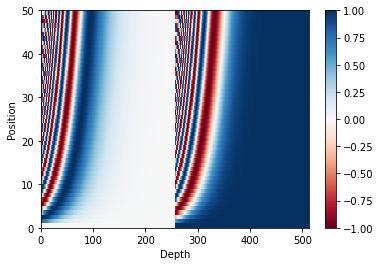

In [143]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

### --- Encoder Layer

In [144]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [145]:
sample_encoder_layer = encoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder_layer"
)

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file="encoder_layer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### --- Encoder

In [146]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [147]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder",
)

tf.keras.utils.plot_model(sample_encoder, to_file="encoder.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### --- Decoder Layer

In [148]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [149]:
sample_decoder_layer = decoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_decoder_layer"
)

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file="decoder_layer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### --- Decoder

In [150]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [151]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder",
)

tf.keras.utils.plot_model(sample_decoder, to_file="decoder.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### --- Transformer

In [152]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [153]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer",
)

tf.keras.utils.plot_model(
    sample_transformer, to_file="transformer.png", show_shapes=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## -- Training

### --- Loss function

In [154]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### --- Custom learning rate

In [155]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = float(d_model)  # use float to avoid save issues
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps,
        }

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

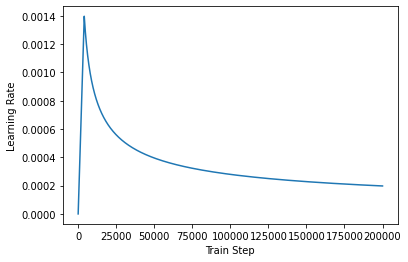

In [156]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### --- Initialize and compile model

In [157]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    print('creating model architecture ...')
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    print('compiling model ...')
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

creating model architecture ...


compiling model ...
Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 256)            1260032   ['inputs[0][0]',              
                                                                    

### --- Fit model

In [158]:
model.fit(dataset, epochs=EPOCHS)
# model.fit(dataset, epochs=10)

Epoch 1/1000
9/9 [==============================] - 54s 1s/step - loss: 2.5180 - accuracy: 4.7660e-04
Epoch 2/1000
9/9 [==============================] - 9s 1s/step - loss: 2.5051 - accuracy: 9.0554e-04
Epoch 3/1000
9/9 [==============================] - 10s 1s/step - loss: 2.4776 - accuracy: 0.0017
Epoch 4/1000
9/9 [==============================] - 9s 1s/step - loss: 2.4416 - accuracy: 0.0094
Epoch 5/1000
9/9 [==============================] - 9s 1s/step - loss: 2.3961 - accuracy: 0.0213
Epoch 6/1000
9/9 [==============================] - 9s 959ms/step - loss: 2.3481 - accuracy: 0.0253
Epoch 7/1000
9/9 [==============================] - 11s 1s/step - loss: 2.3041 - accuracy: 0.0255
Epoch 8/1000
9/9 [==============================] - 11s 1s/step - loss: 2.2631 - accuracy: 0.0254
Epoch 9/1000
9/9 [==============================] - 11s 1s/step - loss: 2.2218 - accuracy: 0.0257
Epoch 10/1000
9/9 [==============================] - 10s 1s/step - loss: 2.1847 - accuracy: 0.0256
Epoch 11/100

### --- Save and load model

In [ ]:
# save model
model.save("chatbot_campus_transformer_model")

INFO:tensorflow:Assets written to: chatbot_campus_transformer_model\assets


INFO:tensorflow:Assets written to: chatbot_campus_transformer_model\assets


In [160]:
# save tokenizer
tokenizer.save_to_file("chatbot_campus_transformer_tokenizer")

In [161]:
"""
del model
tf.keras.backend.clear_session()
"""

'\ndel model\ntf.keras.backend.clear_session()\n'

## -- Evaluate and predict

### --- Predict

In [162]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

question = "Hi, there!"
print(f"Q: {question}");
print(f"A: {predict(question)}")
print("-------------------------------------------")

question = "tell me about admission!"
print(f"Q: {question}");
print(f"A: {predict(question)}")


Q: Hi, there!


A: <a target="\&undscblank" href="$\&undscmap\&undscurl"> here</a>
-------------------------------------------
Q: tell me about admission!
A: application can also be submitted online through the unversity's <a target="\&undscblank" href="$\&undscadmission\&undscurl">website</a>


Text(0.5, 0, 'Train Step')

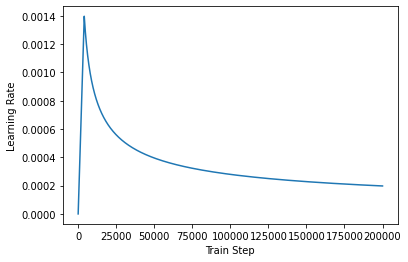

In [163]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### --- Evaluation

#### ---- Prepare Evaluation Data

In [165]:
# Load the intent JSON
with open("intents.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# load data
with open("intents.json", "r", encoding="utf-8") as f:
    intents_data = json.load(f)

questions = []
answers = []
for intent in intents_data["intents"]:
    for pattern in intent.get("patterns", []):
        questions.append(pattern)
        answers.append(random.choice(intent["responses"]))

# preprocess
processed_questions = [preprocess_text_per_word(q) for q in questions]
processed_questions = [apply_ner_tags(text) for text in processed_questions]

valid_questions = []
valid_indices = []
for i, q in enumerate(processed_questions):
    if q.strip():
        valid_questions.append(apply_ner_tags(q))
        valid_indices.append(i)
valid_answers = [answers[i] for i in valid_indices]

# populate bot outputs
bot_outputs = []
# preprocessed_questions_eval_embed = np.array([get_bert_embedding(sentence, tokenizer, bert_model) for sentence in tqdm(preprocessed_questions_eval)])
for i, question in enumerate(tqdm(valid_questions, desc="Generating responses")):
    answer = predict(question)
    bot_outputs.append(answer)
 
print("\nFinal Counts:")
print(f"- Questions: {len(valid_questions)}")
print(f"- Answers: {len(valid_answers)}")
print(f"- Bot Outputs: {len(bot_outputs)}")

print("\nSample:")
print(f"- Questions: {valid_questions[:10]}")
print(f"- Answers: {valid_answers[:10]}")
print(f"- Bot Outputs: {bot_outputs[:10]}")


if len(valid_questions) == len(bot_outputs):
    print("\nAll questions processed successfully")
else:
    print("\nMismatch in input/output counts!")



Generating responses:   0%|          | 0/405 [00:00<?, ?it/s]


Final Counts:
- Questions: 405
- Answers: 405
- Bot Outputs: 405

Sample:
- Questions: ['hi', 'hi', 'how are you ?', 'is anyone there ?', 'hello', 'good day', "what 's up", 'how are ya', 'heyy', 'whatsup']
- Answers: ['Hi there, how can I help?', 'Hello!', 'Hello!', 'Hello!', 'Hello, $_user!', 'Hi there, how can I help?', 'Hi there, how can I help?', 'Hi there, how can I help?', 'Hello, $_user!', 'Good to see you again!']
- Bot Outputs: ['hello, $\\&undscuser!', 'hello, $\\&undscuser!', 'hello, $\\&undscuser!', 'hello, $\\&undscuser!', 'hello, $\\&undscuser!', 'hello, $\\&undscuser!', 'we serve franky, locho, alu-puri, kachori, khavsa, thaali and many more on menu', 'hello, $\\&undscuser!', 'hello, $\\&undscuser!', 'hello, $\\&undscuser!']

All questions processed successfully


#### ---- Rouge Score Evaluation

In [166]:
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Evaluate all
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for ref, hyp in zip(valid_answers, bot_outputs):
    scores = scorer.score(ref, hyp)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

# Average scores
avg_r1 = sum(rouge1_scores) / len(rouge1_scores)
avg_r2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rL = sum(rougeL_scores) / len(rougeL_scores)

print(f"ROUGE-1: {avg_r1:.4f}")
print(f"ROUGE-2: {avg_r2:.4f}")
print(f"ROUGE-L: {avg_rL:.4f}")


ROUGE-1: 0.8303
ROUGE-2: 0.7351
ROUGE-L: 0.8270


#### ---- Bert Score Evaluation

In [167]:
from bert_score import score

# Run BERTScore
P, R, F1 = score(bot_outputs, valid_answers, lang="en", verbose=True)

# Average scores
avg_precision = P.mean().item()
avg_recall = R.mean().item()
avg_f1 = F1.mean().item()

print(f"\nBERTScore:")
print(f"Precision: {avg_precision:.4f}")
print(f"Recall:    {avg_recall:.4f}")
print(f"F1 Score:  {avg_f1:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 25.82 seconds, 15.69 sentences/sec

BERTScore:
Precision: 0.9233
Recall:    0.9464
F1 Score:  0.9344
